Kaan Karakaş 18070001042

**analyze, preprocess and plot data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Data

In [2]:
import pandas as pd
from scipy.stats import boxcox
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/08_Electric_Production.csv")
print(data.head())
print(data.tail())

       DATE  IPG2211A2N
0  1/1/1985     72.5052
1  2/1/1985     70.6720
2  3/1/1985     62.4502
3  4/1/1985     57.4714
4  5/1/1985     55.3151
          DATE  IPG2211A2N
392   9/1/2017     98.6154
393  10/1/2017     93.6137
394  11/1/2017     97.3359
395  12/1/2017    114.7212
396   1/1/2018    129.4048


Converting the Date column into a datetime object

In [3]:
data['DATE'] = pd.to_datetime(data['DATE'], format='%m/%d/%Y')
print(data.head())

        DATE  IPG2211A2N
0 1985-01-01     72.5052
1 1985-02-01     70.6720
2 1985-03-01     62.4502
3 1985-04-01     57.4714
4 1985-05-01     55.3151


In [4]:
data.index = data['DATE']
del data['DATE']
print(data.head())

            IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def plot_ts(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    # plt.figure(figsize=(12,5), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

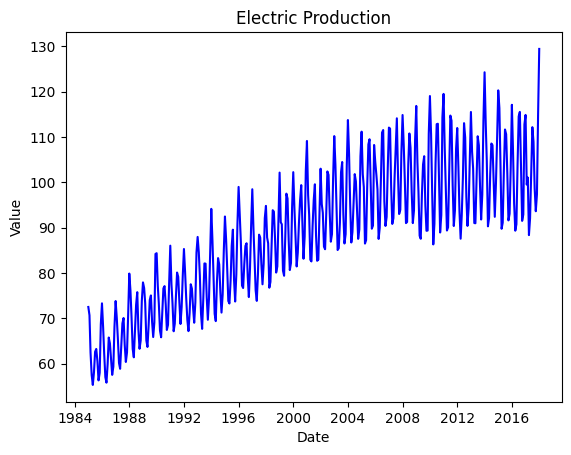

In [7]:
#plot data
plot_ts(data, x=data.index, y=data["IPG2211A2N"], title="Electric Production")

**check and plot Data Stationarity in data. Comment and fix if it needs to be fixed**

testing for stationarity. Calculating a 12-month rolling mean

In [8]:
def rolling_stats(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()
    plt.plot(df, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.xlabel('Date', size=12)
    plt.ylabel('Value', size=12)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()

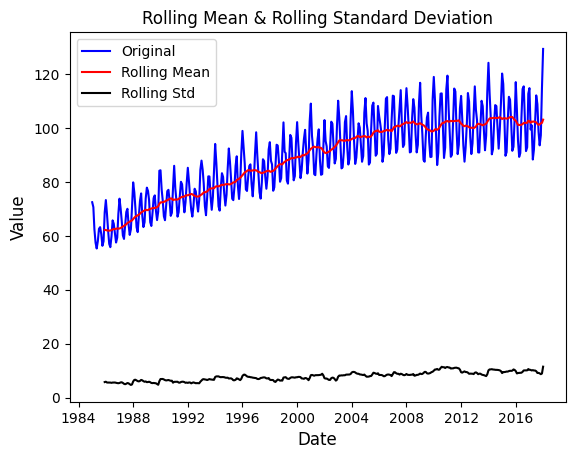

In [9]:
rolling_stats(data)

augmented Dickey-Fuller test from the statsmodels

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
def checkStationary(dfCheck):
    adft = adfuller(dfCheck,autolag="AIC")
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                                            "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df)

In [12]:
checkStationary(data)

       Values                       Metric
0   -2.256990              Test Statistics
1    0.186215                      p-value
2   15.000000             No. of lags used
3  381.000000  Number of observations used
4   -3.447631          critical value (1%)
5   -2.869156          critical value (5%)
6   -2.570827         critical value (10%)


P > 0.05 so this is not stationary. It need to be fixed

Now I will fix statiority

In [13]:
def fixStationary(dfLog):
    print("after fixing stationary")
    dfNew = dfLog.copy()
    dfNew['IPG2211A2N'] = boxcox(dfLog['IPG2211A2N'], lmbda=0.0)
    checkStationary(dfNew)
    plot_ts(dfNew, x=dfNew.index, y=dfNew["IPG2211A2N"], title="After Fixing Stationary")
    return dfNew

after fixing stationary
       Values                       Metric
0   -3.145360              Test Statistics
1    0.023373                      p-value
2   15.000000             No. of lags used
3  381.000000  Number of observations used
4   -3.447631          critical value (1%)
5   -2.869156          critical value (5%)
6   -2.570827         critical value (10%)


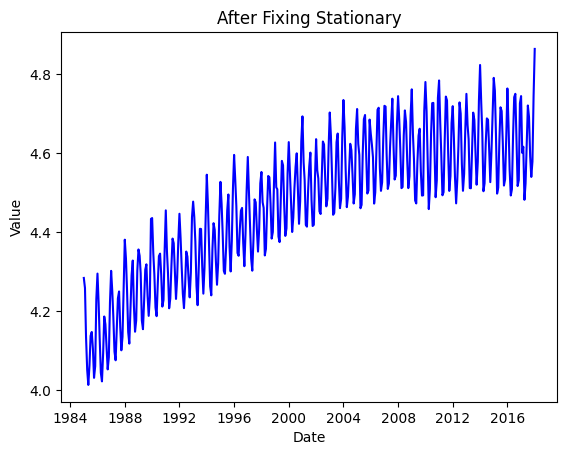

In [14]:
data =fixStationary(data)

eliminate the long-term trend in the time series data, leaving behind the short-term variations or fluctuations. 

In [15]:
def removeTrendWithMovingAverage(dfLog):
    moving_avg = dfLog.rolling(window=12).mean()
    dfNew = dfLog - moving_avg
    dfNew.dropna(inplace=True)
    return dfNew

In [16]:
data = removeTrendWithMovingAverage(data)

**check and plot auto correlation. Comment**

In [17]:
def Autocorrelation():
    autocorrelation_lag1 = data['IPG2211A2N'].autocorr(lag=1)
    print("One Month Lag: ", autocorrelation_lag1)

    # try three, six and nine months:
    # the data is highly autocorrelated.
    autocorrelation_lag3 = data['IPG2211A2N'].autocorr(lag=3)
    print("Three Month Lag: ", autocorrelation_lag3)

    autocorrelation_lag6 = data['IPG2211A2N'].autocorr(lag=6)
    print("Six Month Lag: ", autocorrelation_lag6)

    autocorrelation_lag9 = data['IPG2211A2N'].autocorr(lag=9)
    print("Nine Month Lag: ", autocorrelation_lag9)

    #plot autocorrelation
    lags = [1, 3, 6, 9]
    autocorrelations = [autocorrelation_lag1, autocorrelation_lag3, autocorrelation_lag6, autocorrelation_lag9]
    plt.figure(figsize=(8, 6))
    plt.bar(lags, autocorrelations)
    plt.title('Autocorrelation at Different Lags')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()  

One Month Lag:  0.5096471571496536
Three Month Lag:  -0.7988203750461059
Six Month Lag:  0.7237997309921865
Nine Month Lag:  -0.8214192742827232


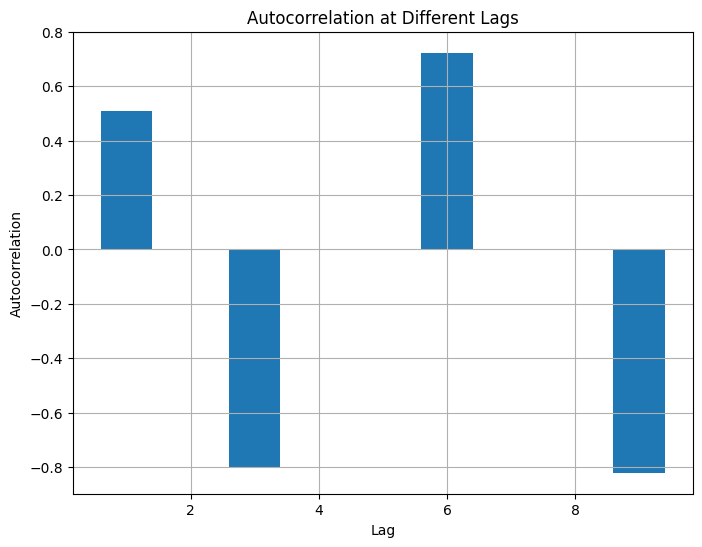

In [18]:
Autocorrelation()

For one month lag and six month lag, there is positive linear relationship between the current month's values and the values of the previous months. This indicates some degree of persistence or momentum in the data. For three and nine month,There is a negative linear relationship between the current month's value and the value nine months ago. This shows a significant inverse relationship or seasonality pattern every nine or three months.

**plot decompoisition graphs**

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposePlot():
    decompose = seasonal_decompose(data['IPG2211A2N'],model='additive', period=7)
    decompose.plot()

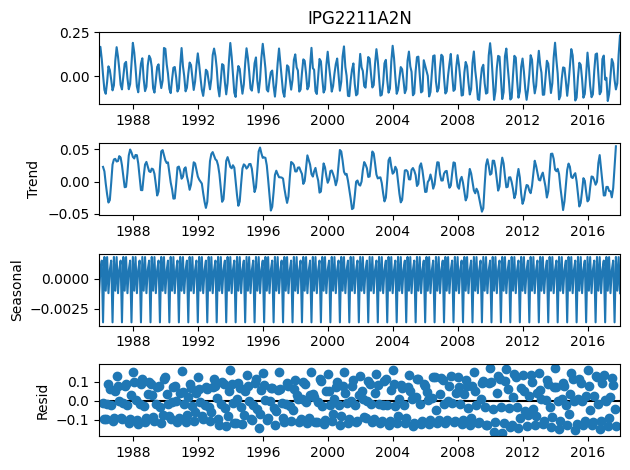

In [20]:
decomposePlot()

**create train and test data using date ranges or length**

In [21]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.4 MB/s eta 0:00:00


In [22]:
import statsmodels.api as sm
from pmdarima.arima import auto_arima

Using ARIMA to create model and predict

<ipython-input-25-d68010089b76>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['IPG2211A2N']
<ipython-input-25-d68010089b76>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['IPG2211A2N']


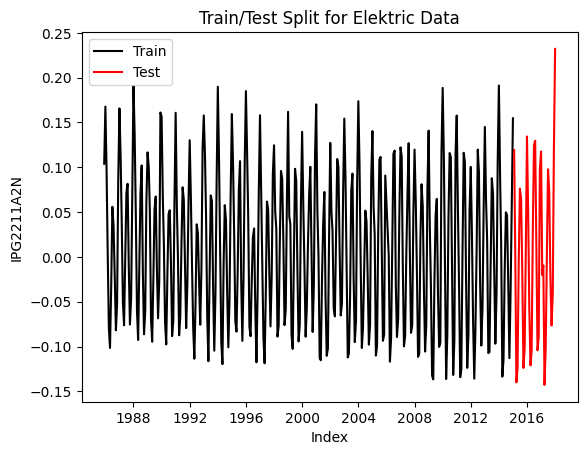

In [25]:
# Create train and test data based on length. We have 398 data.
train_length = 350
test_length = 47

train = data.iloc[:train_length]
train['train'] = train['IPG2211A2N']
del train['IPG2211A2N']

test = data.iloc[train_length:train_length + test_length]
test['test'] = test['IPG2211A2N']
del test['IPG2211A2N']

# Plot train and test data
plt.plot(train['train'], color="black", label="Train")
plt.plot(test['test'], color="red", label="Test")
plt.title("Train/Test Split for Elektric Data")
plt.ylabel("IPG2211A2N")
plt.xlabel("Index")
plt.legend()
sns.set()
plt.show()

**using AutoArima, find optimal parameters and create model. plot the model performance and check by using RMSE**

In [26]:
model_auto_arima = auto_arima(train, start_p=1, start_q=1, d=1,
                              max_p=12, max_q=12, max_d=6, D=1, start_P=1, start_Q=1, max_D=6,
                              max_P=6, max_Q=6, m=12, seasonal=True,
                              error_action='warn', suppress_warnings=True, random_state=100)
model_auto_arima

ARIMA(order=(0, 1, 4), scoring_args={}, seasonal_order=(3, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [28]:
#create model
model_arima = sm.tsa.arima.ARIMA(train, order=(0, 1, 4), seasonal_order=(3, 1, 1, 12))
model_fit_arima = model_arima.fit()
model_fit_arima.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              train   No. Observations:                  350
Model:             ARIMA(0, 1, 4)x(3, 1, [1], 12)   Log Likelihood                 808.029
Date:                            Thu, 11 May 2023   AIC                          -1598.058
Time:                                    15:24:53   BIC                          -1563.678
Sample:                                12-01-1985   HQIC                         -1584.355
                                     - 01-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4745      0.062     -7.598      0.000      -0.597      -0.352
ma.L2         -0.2801      0.064     -4.345      0.000      -0.407      -0.154
ma.L3         -0.1024      0.074     -1.375      0.169      -0.248       0.044
ma.L4         -0.1220      0.062     -1.953      0.051      -0.244       0.000
ar.S.L12       0.0042      0.099      0.043      0.966      -0.189       0.197
ar.S.L24      -0.1518      0.077     -1.980      0.048      -0.302      -0.002
ar.S.L36       0.0065      0.075      0.087      0.931      -0.140       0.153
ma.S.L12      -0.7687      0.079     -9.733      0.000      -0.924      -0.614
sigma2         0.0005   3.95e-05     11.906      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 8.28
Prob(Q):                              0.84   Prob(JB):                         0.02
Heteroskedasticity (H):               1.62   Skew:                            -0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

create prediction and compare, train test and prediction

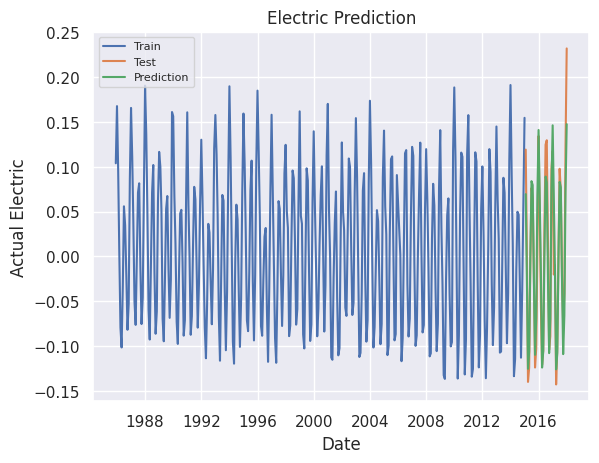

In [29]:
forecast = model_fit_arima.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('Electric Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Electric')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
#check by using RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error
# # the average difference between values predicted by a model and the actual values
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  0.032153657268871164


**predict the production between 2022-01 and 2022-12**

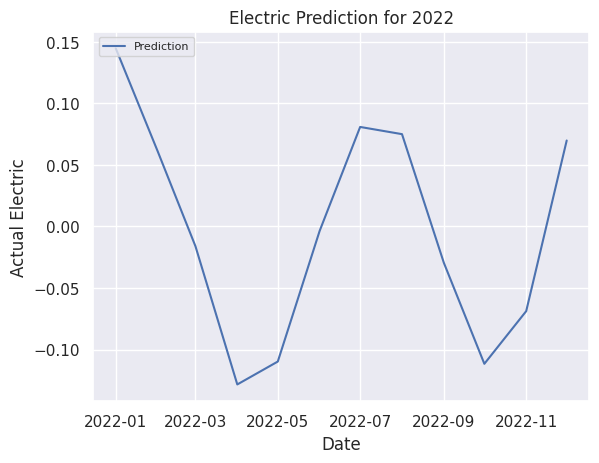

In [31]:
forecast2 = model_fit_arima.predict(start=pd.to_datetime("2022-01", format='%Y-%m'),
                                    end=pd.to_datetime("2022-12", format='%Y-%m'), dynamic=False)
plt.plot(forecast2, label='Prediction')
plt.title('Electric Prediction for 2022')
plt.xlabel('Date')
plt.ylabel('Actual Electric')
plt.legend(loc='upper left', fontsize=8)
plt.show()